In [1]:
import pandas as pd
import re


df_nim = pd.read_csv('time_nim.tsv', sep='\t')
df_b0 = pd.read_csv('time_b0.tsv', sep='\t')
df_b4 = pd.read_csv('time_b4.tsv', sep='\t')
df_b0.columns = ['file', 'mean_group1_s', 'mean_group2_s', 'time']
df_b4.columns = ['file', 'mean_group1_s', 'mean_group2_s', 'time']
df_nim.columns = ['file', 'mean_group1_s', 'mean_group2_s', 'time']

def enrich_df(df, mode_hint=None):
    df = df.copy()
    
    def extract_dataset(filename):
        m = re.match(r'^(L\d+)', filename)
        return m.group(1) if m else None
    def extract_steps(filename):
        m = re.search(r'_(10|200)\.txt$', filename)
        return int(m.group(1)) if m else None
    def detect_mode(filename):
        fname = filename.lower()
        if "nim" in fname:
            return "boltz2nim"
        if "_b0" in fname or "_b0_py" in fname:
            return "boltz2"
        
        return "boltz2b"
    df["dataset"] = df["file"].apply(extract_dataset)
    df["sampling_steps"] = df["file"].apply(extract_steps)
    
    if mode_hint is not None:
        df["mode"] = mode_hint
    else:
        df["mode"] = df["file"].apply(detect_mode)
    
    cols = ["file", "mode", "dataset", "sampling_steps"] + [c for c in df.columns if c not in ["file","mode","dataset","sampling_steps"]]
    return df[cols]

df_nim_e = enrich_df(df_nim)
df_b0_e  = enrich_df(df_b0)
df_b4_e  = enrich_df(df_b4)
df = pd.concat([df_nim_e, df_b0_e, df_b4_e], ignore_index=True, sort=False)
df = df.sort_values(by=["dataset", "sampling_steps", "mode"]).reset_index(drop=True)


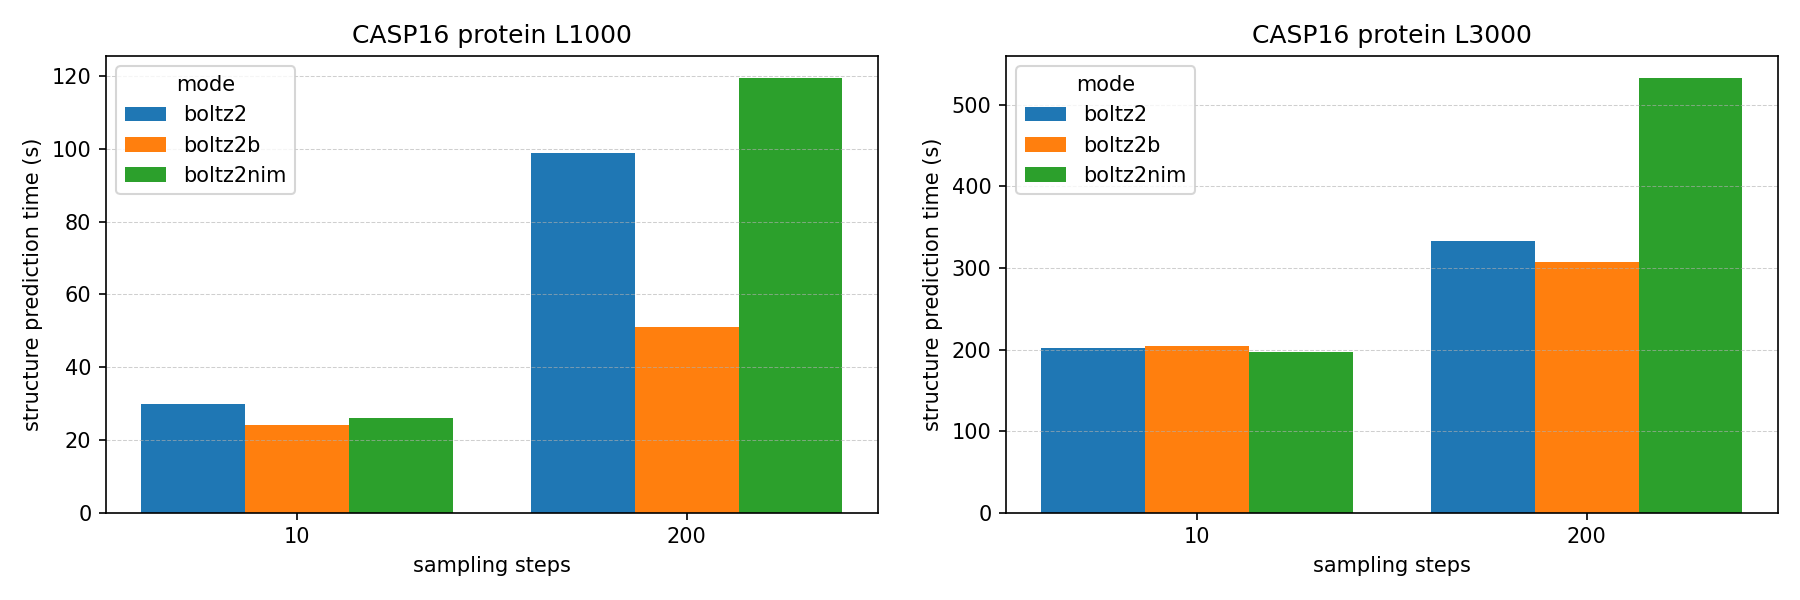

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
from IPython.display import display


raw_max = df['mean_group1_s'].max()
ymax = math.ceil(raw_max * 1.05 / 10) * 10

out_dir = ""
file_L1000 = os.path.join(out_dir, "mean_group1_L1000_commonY.png")
file_L3000 = os.path.join(out_dir, "mean_group1_L3000_commonY.png")
combined_file = os.path.join(out_dir, "mean_group1_L1000_L3000_commonY_side_by_side.png")

def plot_and_save(df, dataset, out_path, ymax):
    df_ds = df[df['dataset'] == dataset].copy()
    pivot = df_ds.pivot_table(index='sampling_steps', columns='mode', values='mean_group1_s')
    pivot = pivot.sort_index()
    modes = pivot.columns.tolist()
    n_groups = len(pivot.index)
    x = np.arange(n_groups)
    width = 0.8 / len(modes)
    
    plt.figure(figsize=(6,4))
    for i, mode in enumerate(modes):
        plt.bar(x + i*width, pivot[mode].values, width, label=mode)
    xtick_positions = x + width*(len(modes)-1)/2
    xtick_labels = [f"{int(ss)}" for ss in pivot.index]
    plt.xticks(xtick_positions, xtick_labels)
    plt.xlabel("sampling steps")
    plt.ylabel("structure prediction time (s)")
    plt.title(f"CASP16 protein {dataset}")
    plt.legend(title="mode")
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

plot_and_save(df, "L1000", file_L1000, ymax)
plot_and_save(df, "L3000", file_L3000, ymax)

img1 = Image.open(file_L1000)
img2 = Image.open(file_L3000)
h = max(img1.height, img2.height)
def scale_to_height(img, target_h):
    if img.height == target_h:
        return img
    w = int(img.width * (target_h / img.height))
    return img.resize((w, target_h), Image.LANCZOS)
img1s = scale_to_height(img1, h)
img2s = scale_to_height(img2, h)
combined = Image.new('RGB', (img1s.width + img2s.width, h), (255,255,255))
combined.paste(img1s, (0,0))
combined.paste(img2s, (img1s.width,0))
combined_file = 'bars_structure.png'
combined.save(combined_file)
display(Image.open(combined_file))
!rm $file_L1000
!rm $file_L3000


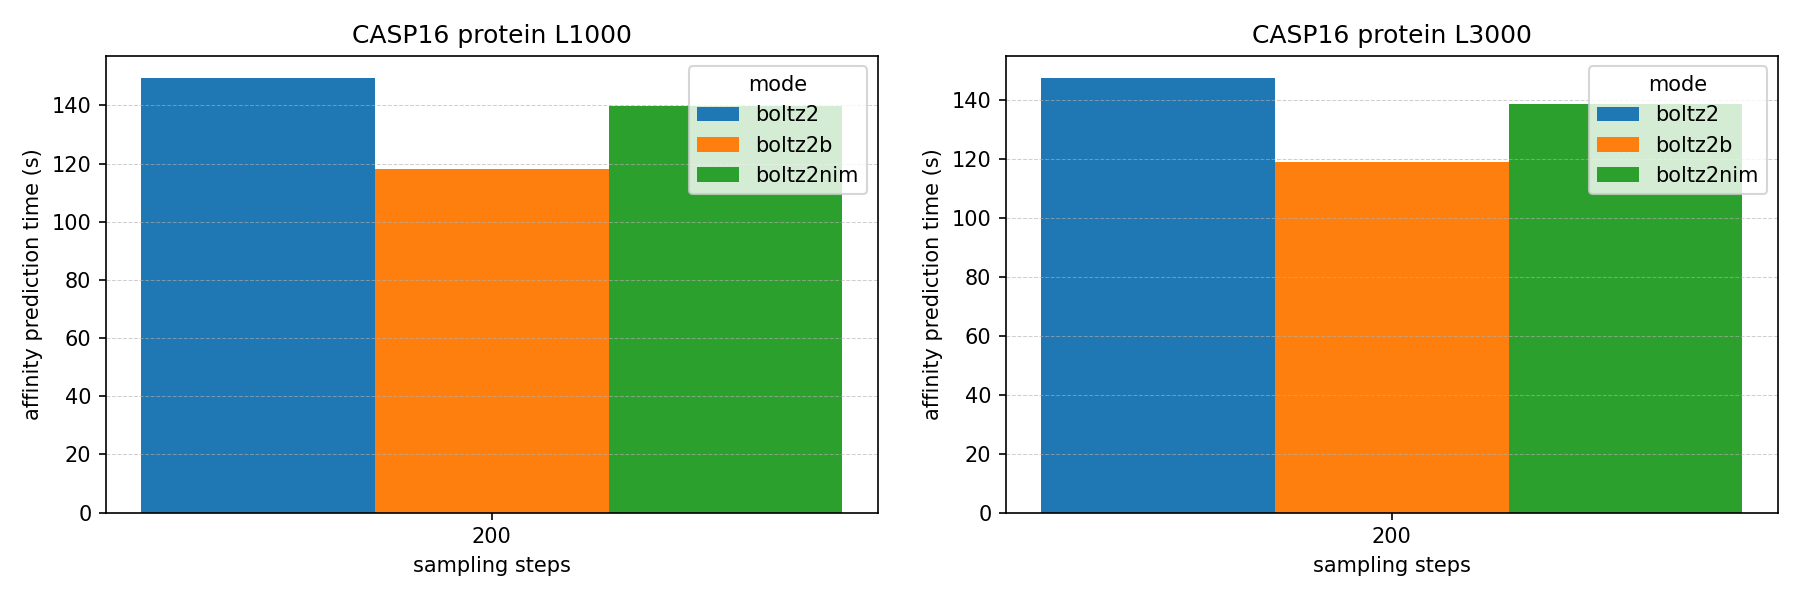

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import math
from IPython.display import display


df2 = df[['mode', 'dataset', 'mean_group2_s']]
df2 = df2.groupby(by=['mode', 'dataset'], as_index=False).mean()
df2['sampling_steps']=200
raw_max = df['mean_group1_s'].max()
ymax = math.ceil(raw_max * 1.05 / 10) * 10
out_dir = ""
file_L1000 = os.path.join(out_dir, "mean_group1_L1000_commonY.png")
file_L3000 = os.path.join(out_dir, "mean_group1_L3000_commonY.png")
combined_file = os.path.join(out_dir, "mean_group1_L1000_L3000_commonY_side_by_side.png")

def plot_and_save(df, dataset, out_path, ymax):
    df_ds = df[df['dataset'] == dataset].copy()
    pivot = df_ds.pivot_table(index='sampling_steps', columns='mode', values='mean_group2_s')
    pivot = pivot.sort_index()
    modes = pivot.columns.tolist()
    n_groups = len(pivot.index)
    x = np.arange(n_groups)
    width = 0.8 / len(modes)
    plt.figure(figsize=(6,4))
    for i, mode in enumerate(modes):
        plt.bar(x + i*width, pivot[mode].values, width, label=mode)
    xtick_positions = x + width*(len(modes)-1)/2
    xtick_labels = [f"{int(ss)}" for ss in pivot.index]
    plt.xticks(xtick_positions, xtick_labels)
    plt.xlabel("sampling steps")
    plt.ylabel("affinity prediction time (s)")
    plt.title(f"CASP16 protein {dataset}")
    plt.legend(title="mode")
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

plot_and_save(df2, "L1000", file_L1000, ymax)
plot_and_save(df2, "L3000", file_L3000, ymax)

img1 = Image.open(file_L1000)
img2 = Image.open(file_L3000)
h = max(img1.height, img2.height)
def scale_to_height(img, target_h):
    if img.height == target_h:
        return img
    w = int(img.width * (target_h / img.height))
    return img.resize((w, target_h), Image.LANCZOS)
img1s = scale_to_height(img1, h)
img2s = scale_to_height(img2, h)
combined = Image.new('RGB', (img1s.width + img2s.width, h), (255,255,255))
combined.paste(img1s, (0,0))
combined.paste(img2s, (img1s.width,0))
combined_file = 'bars_affinity.png'
combined.save(combined_file)
display(Image.open(combined_file))
!rm $file_L1000
!rm $file_L3000
